## Making a Potential Energy Curve of an I$^-$-H$_2$O dimer
And comparing it to the ASE potential.


Imports:

In [2]:
import numpy as np
import sys, matplotlib
sys.path.append('../../')

%matplotlib notebook
import matplotlib.pyplot as plt
matplotlib.rc('text', usetex=True)
matplotlib.rc('text.latex', preamble=r'\usepackage{cmbright}')
plt.rcParams.update({'font.size': 16})
plt.rcParams.update({'figure.autolayout': True})

from cmm.tools.ase_openmm import OpenMMCalc
from cmm.tools.tip4pew import angleHOH, rOH, TIP4PEW
from cmm.tools.tip4pew import TIP4PEW, sigma0 as sig_ew, epsilon0 as eps_ew

import ase.units as ase_u
from ase import Atoms
from ase.calculators.tip4p import TIP4P, sigma0, epsilon0
from ase.calculators.combine_mm import CombineMM
from ase.calculators.counterions import AtomicCounterIon as ACI

from simtk import unit as u
from simtk import openmm as mm
from simtk.openmm.openmm import NonbondedForce


Define helper functions

In [3]:
def make_ase_atoms(sig, eps, r, chrg=-1, calc2=TIP4P, sig2=sigma0, eps2=epsilon0):
    ''' Setup the dimer and the ASE calculator '''
    x = angleHOH * np.pi / 180 / 2
    pos = [[0, r, 0],
           [0, 0, 0],
           [0, rOH * np.cos(x), rOH * np.sin(x)],
           [0, rOH * np.cos(x), -rOH * np.sin(x)]]
    atoms = Atoms('IOH2', positions=pos)
    calc = CombineMM([0], apm1=1, apm2=3,  
                     calc1=ACI(chrg, eps, sig),  
                     calc2=calc2(),  
                     sig1=[sig], eps1=[eps], 
                     sig2=np.array([sig2, 0, 0]), eps2=np.array([eps2, 0, 0]),
                     rc=100) 
    atoms.calc = calc
    return atoms

def make_omm_atoms(r=3):
    ''' Make OpenMM atoms object, it needs the virtual charge site exposed'''
    x = angleHOH * np.pi / 180 / 2
    pos = [[0, r, 0],
           [0, 0, 0],
           [0, rOH * np.cos(x), rOH * np.sin(x)],
           [0, rOH * np.cos(x), -rOH * np.sin(x)]]

    tip4 = TIP4PEW().add_virtual_sites(np.array(pos[1:]))
    pos = np.vstack((pos[0], tip4))
    atoms = Atoms('IOH2He', positions=pos)
    return atoms

def get_lj(atoms, idx):
    ''' Get LJ parameters from OpenMM '''
    sigma = np.nan
    epsilon = np.nan
    for force in atoms.calc.sys.getForces():
        if isinstance(force, NonbondedForce):
            for i in range(force.getNumParticles()):
                if i == idx:
                    charge, sigma, epsilon = force.getParticleParameters(i)
                    sigma = sigma.in_units_of(u.angstrom)._value
                    epsilon = epsilon.in_units_of(u.kilojoule_per_mole)._value * ase_u.kJ / ase_u.mol

    return sigma, epsilon



<IPython.core.display.Javascript object>


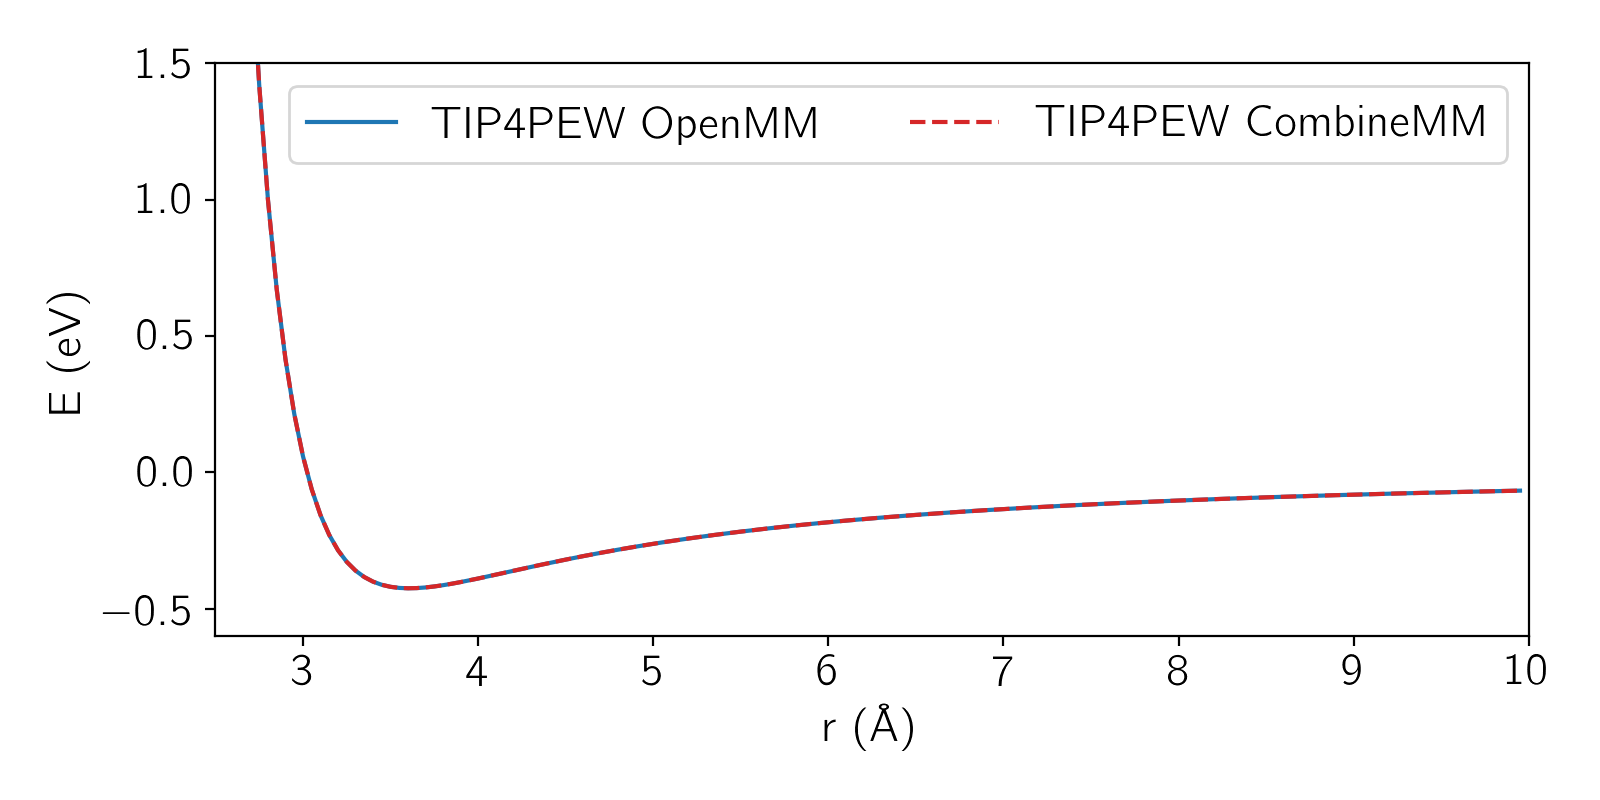

In [6]:
rs = np.arange(1.5, 10, 0.05)
omm_ener = np.zeros(len(rs))
ase_ener = np.zeros(len(rs))

pes_traj = []

for i, r in enumerate(rs):
    # Get OpenMM Energies:
    omm_atoms = make_omm_atoms(r)
    calc = OpenMMCalc([['I'], ['HOH', 'HOH', 'HOH', 'HOH']])
    calc.make_topology(omm_atoms)
    omm_atoms.calc = calc
    omm_ener[i] = omm_atoms.get_potential_energy()
    
    pes_traj.append(omm_atoms)
    
    # Get ASE energies
    if i == 0: 
        sigma, epsilon = get_lj(omm_atoms, 0)
    
    ase_atoms = make_ase_atoms(sigma, epsilon, r, calc2=TIP4PEW, sig2=sig_ew, eps2=eps_ew)
    ase_ener[i] = ase_atoms.get_potential_energy()



fig, ax = plt.subplots(1, 1, figsize=(8, 4));
ax.plot(rs, omm_ener, label='TIP4PEW OpenMM')
ax.plot(rs, ase_ener, '--', color=f'C{3}', label='TIP4PEW' + ' CombineMM' )

ax.set_ylim([-0.6, 1.5])
ax.set_xlim([2.5, 10])
ax.legend(loc='best', ncol=2)
ax.set_xlabel('r (Å)')
ax.set_ylabel('E (eV)');

View the scanned frames (requires nglview)

In [7]:
from ase.visualize import view
view(pes_traj, viewer='ngl')